# Notebook made for case interview for DS position on a factory (Feb 2022)

**Key objective:**
The factory is producing jars of instant coffee. Each jar of coffee is inspected by a camera and characterized by 1558 features. Jars were visually inspected and classified as good (no defects) or bad (there is at least 1 defect detected by the camera).
The company would like to automatically classify the jars into good or bad ones based on these features. To do this a machine learning model must be built that can automatically detect the defective jars. 

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

import tensorflow as tf
from tensorflow import keras

In [2]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
mpl.rcParams['figure.figsize'] = (12, 10)

In [3]:
raw_df = pd.read_excel('/content/drive/MyDrive/Tests/Data Science Test.xlsx')

Let's have a first look at the data

In [4]:
raw_df.describe()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_1550,feature_1551,feature_1552,feature_1553,feature_1554,feature_1555,feature_1556,feature_1557,feature_1558,Class
count,1726.000000,1726.000000,1726.000000,1726.000000,1726.000000,1726.000000,1726.000000,1726.000000,1726.000000,1726.000000,...,1726.000000,1726.000000,1726.000000,1726.000000,1726.000000,1726.000000,1726.000000,1726.000000,1726.000000,1726.000000
mean,53.052144,123.877173,15.511342,0.724218,0.002897,0.002897,0.008111,0.002317,0.004635,0.011587,...,0.004056,0.005794,0.002897,0.003476,0.004056,0.015064,0.014484,0.009270,0.001159,0.061414
std,56.172526,126.644810,23.312613,0.447037,0.053760,0.053760,0.089722,0.048099,0.067943,0.107051,...,0.063573,0.075918,0.053760,0.058874,0.063573,0.121842,0.119511,0.095861,0.034031,0.240157
min,1.000000,1.000000,0.001500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.000000,33.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,38.000000,96.000000,4.750000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,75.000000,152.750000,16.923000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,640.000000,640.000000,236.842000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
raw_df.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_1550,feature_1551,feature_1552,feature_1553,feature_1554,feature_1555,feature_1556,feature_1557,feature_1558,Class
0,100,160,1.600,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,20,83,4.150,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,99,150,15.151,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,40,40,1.000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12,234,19.500,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Looks like we have 3 features with numerical data and 1555 categorical features

In [6]:
num_cols = []
cat_cols = []
for name in raw_df.columns:
  if name == 'Class': continue
  if raw_df[name].isin([0,1]).all():
    cat_cols.append(name)
    continue
  else:
    num_cols.append(name)
    print(f'Numerical column: {name}')
feature_cols = num_cols + cat_cols
target_col = 'Class'

Numerical column: feature_1
Numerical column: feature_2
Numerical column: feature_3


Inspect distribution of numerical columns and sum of categorical features as a simple generated feature

In [7]:
mod_df = raw_df.copy()
mod_df['cat_sum'] = mod_df[cat_cols].sum(axis=1)

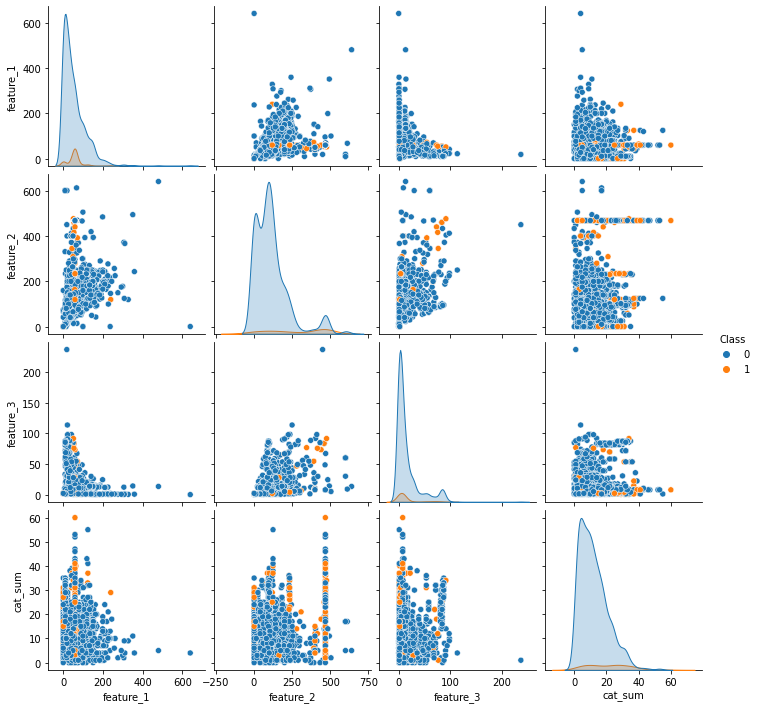

In [8]:
sns.pairplot(mod_df[['feature_1', 'feature_2', 'feature_3', 'cat_sum', 'Class']], hue='Class')

Number of bad jars: 106, (6.14% of total)


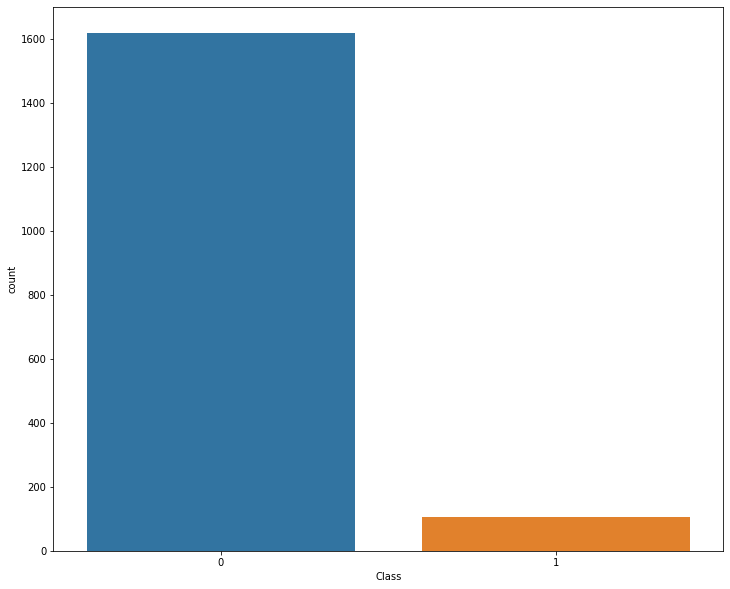

In [9]:
good, bad = np.bincount(raw_df['Class'])
total = good + bad
print(f'Number of bad jars: {bad}, ({bad / total * 100 :.2f}% of total)')
sns.countplot(x = raw_df['Class'])

Classes could be called imbalanced

Time to split the dataset

In [20]:
train_df, test_df = train_test_split(raw_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)
train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)


In [21]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)


Training labels shape: (1104,)
Validation labels shape: (276,)
Test labels shape: (346,)
Training features shape: (1104, 1558)
Validation features shape: (276, 1558)
Test features shape: (346, 1558)


The most simple model to try

In [22]:
CV = GridSearchCV(estimator=LogisticRegression(),
                  param_grid={'C':[100, 10, 1, 0.1, 0.01, 0.001]},
                  cv=5,
                  scoring='accuracy',
                  n_jobs=-1,
                  verbose=10)

Accuracy is used to score the model as if false negative and false positive (good jars to be wasted and bad jars to be delivered to customer) have the same value.

In [23]:
CV.fit(train_features, train_labels)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [100, 10, 1, 0.1, 0.01, 0.001]},
             scoring='accuracy', verbose=10)

In [24]:
CV.cv_results_['mean_test_score']

array([0.8949239 , 0.91213492, 0.92391197, 0.93297408, 0.9311559 ,
       0.94384204])

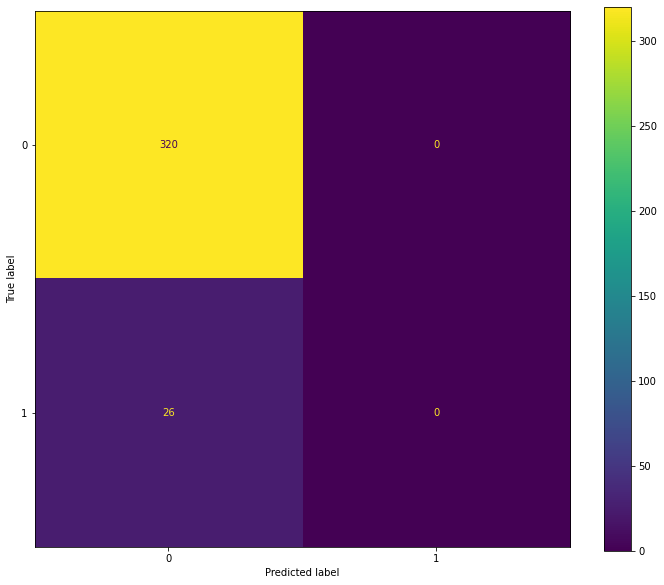

In [25]:
ConfusionMatrixDisplay.from_estimator(CV, test_features, test_labels)

Accuracy was quite good for this model, but in fact predicted none bad jars

Now we could try Support Vector Classification

In [26]:
CV_SVC = GridSearchCV(estimator=SVC(),
                      param_grid={'C':[100, 10, 1, 0.1, 0.01, 0.001]},
                      cv=5,
                      scoring='accuracy',
                      n_jobs=-1,
                      verbose=10)

In [27]:
CV_SVC.fit(train_features, train_labels)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [100, 10, 1, 0.1, 0.01, 0.001]},
             scoring='accuracy', verbose=10)

In [28]:
CV_SVC.cv_results_['mean_test_score']

array([0.92935829, 0.93207322, 0.93749897, 0.94384204, 0.94384204,
       0.94384204])

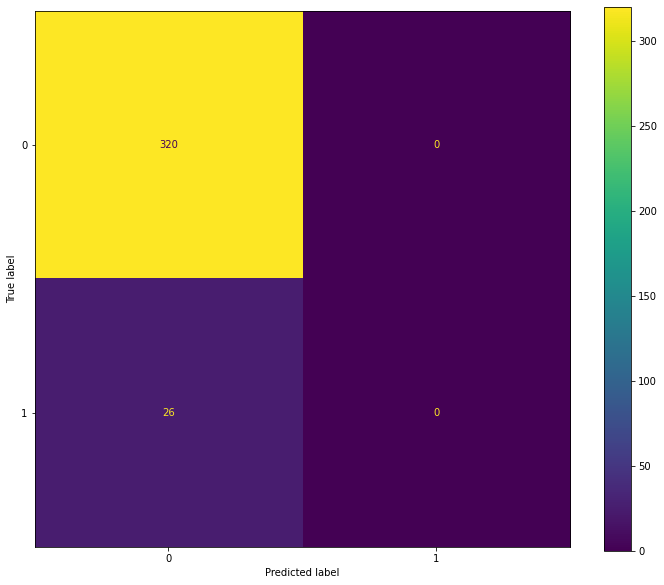

In [29]:
ConfusionMatrixDisplay.from_estimator(CV_SVC, test_features, test_labels)

Has not found any bad jars.

Time for nearest neighbors

In [30]:
CV_KNN = GridSearchCV(estimator=KNeighborsClassifier(),
                      param_grid={'n_neighbors':[3, 4, 5, 6, 7, 8]},
                      cv=5,
                      scoring='accuracy',
                      n_jobs=-1,
                      verbose=10)

In [31]:
CV_KNN.fit(train_features, train_labels)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 4, 5, 6, 7, 8]}, scoring='accuracy',
             verbose=10)

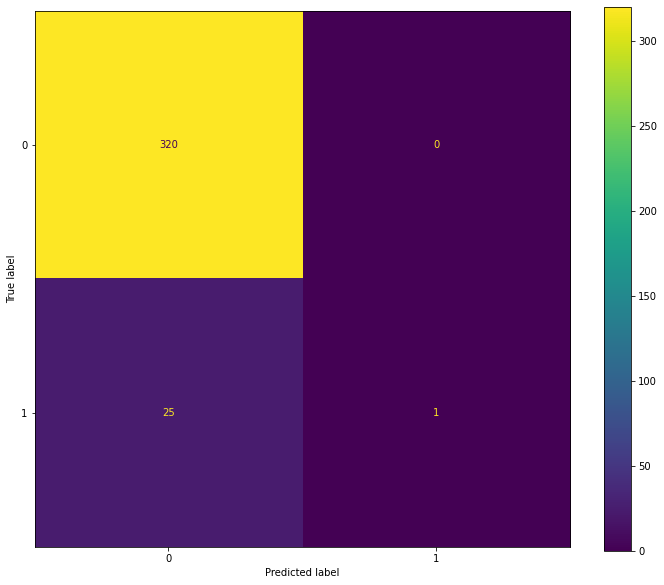

In [32]:
ConfusionMatrixDisplay.from_estimator(CV_KNN, test_features, test_labels)

In [33]:
CV_KNN.cv_results_['mean_test_score']

array([0.93840806, 0.94475113, 0.94293295, 0.94203209, 0.94113534,
       0.94112711])

In [34]:
CV_KNN.score(test_features, test_labels)

0.9277456647398844

In [35]:
gbs = GradientBoostingClassifier(n_estimators=200, max_depth=4)

In [36]:
gbs.fit(train_features, train_labels)

GradientBoostingClassifier(max_depth=4, n_estimators=200)

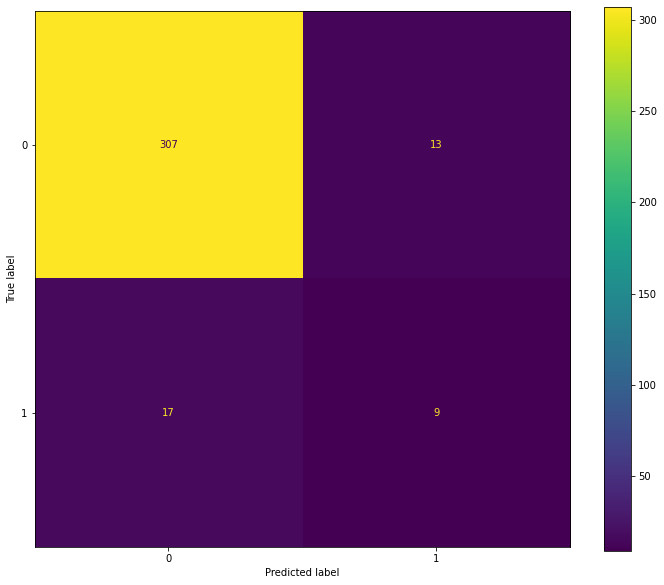

In [37]:
ConfusionMatrixDisplay.from_estimator(gbs, test_features, test_labels)

Time for real neural networks

In [38]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR')
]

In [39]:
def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])
  model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=metrics)

  return model

In [40]:
EPOCHS = 100
BATCH_SIZE = 100

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)


In [41]:
model = make_model()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                24944     
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 24,961
Trainable params: 24,961
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.predict(train_features[:10])


array([[0.3626781 ],
       [0.310206  ],
       [0.23935851],
       [0.19678527],
       [0.28674668],
       [0.37675515],
       [0.33512744],
       [0.2557979 ],
       [0.27325934],
       [0.24162218]], dtype=float32)

In [43]:
initial_bias = np.log([bad/good])
initial_bias

array([-2.72674233])

In [44]:
model = make_model(output_bias=initial_bias)

In [45]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.2267


In [46]:
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100
12/12 [==============================] - 2s 13ms/step - loss: 0.2109 - tp: 4.0000 - fp: 7.0000 - tn: 1035.0000 - fn: 58.0000 - accuracy: 0.9411 - precision: 0.3636 - recall: 0.0645 - auc: 0.7034 - prc: 0.1544 - val_loss: 0.2119 - val_tp: 0.0000e+00 - val_fp: 2.0000 - val_tn: 256.0000 - val_fn: 18.0000 - val_accuracy: 0.9275 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8492 - val_prc: 0.2691
Epoch 2/100
12/12 [==============================] - 0s 10ms/step - loss: 0.1806 - tp: 5.0000 - fp: 4.0000 - tn: 1038.0000 - fn: 57.0000 - accuracy: 0.9447 - precision: 0.5556 - recall: 0.0806 - auc: 0.8004 - prc: 0.2775 - val_loss: 0.1899 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 257.0000 - val_fn: 18.0000 - val_accuracy: 0.9312 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8885 - val_prc: 0.3894
Epoch 3/100
12/12 [==============================] - 0s 11ms/step - loss: 0.1668 - tp: 8.0000 - fp: 5.0000 - tn: 1037.0000 - fn: 54.0000 - accurac

In [47]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();


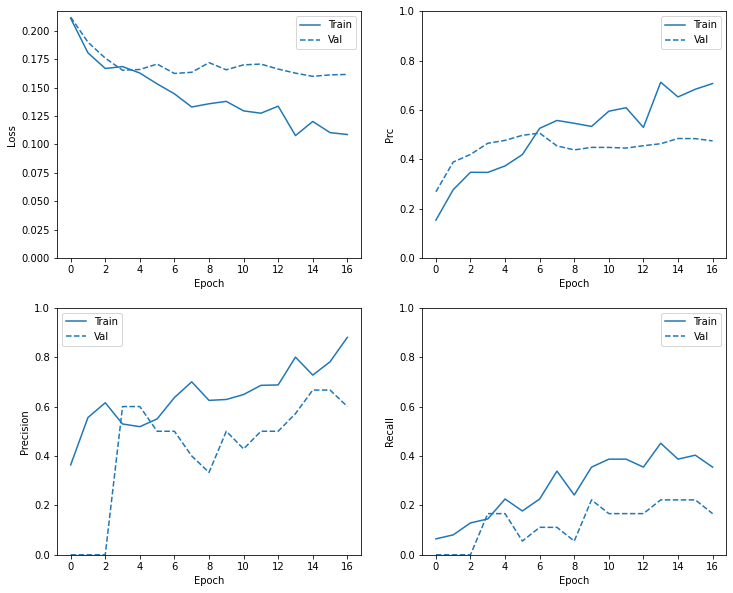

In [48]:
plot_metrics(baseline_history)

NN does not seem to be learning at all

In [49]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)

In [50]:
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)


In [51]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')


loss :  0.1868135929107666
tp :  1.0
fp :  2.0
tn :  318.0
fn :  25.0
accuracy :  0.9219653010368347
precision :  0.3333333432674408
recall :  0.03846153989434242
auc :  0.9108774065971375
prc :  0.470203697681427



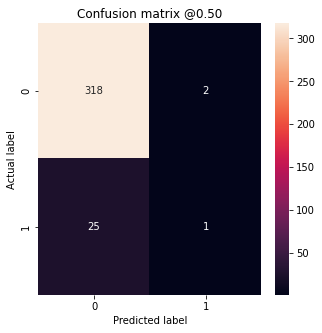

In [52]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)


Found 1 bad jar and wasted 2 good ones

Now pytorch which is more familiar to me

In [53]:
!pip install -q catalyst

     |████████████████████████████████| 446 kB 28.8 MB/s 
     |████████████████████████████████| 125 kB 56.5 MB/s 
     |████████████████████████████████| 123 kB 45.3 MB/s 


In [54]:
!pip install -q torchinfo

In [55]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchinfo import summary
from catalyst import utils
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [56]:
class NeuralNetwork(nn.Module):
  def __init__(self, in_features: int, out_features: int):
    super(NeuralNetwork, self).__init__()
    self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_features, 1558),
            nn.ReLU(),
            nn.Linear(1558, 1558),
            nn.ReLU(),
            nn.Linear(1558, out_features),
        )
  def forward(self, x):
    logits = self.linear_relu_stack(x)
    return logits

In [57]:
X_train =  torch.tensor(train_features, dtype=torch.float32)
y_train =  torch.tensor(train_labels, dtype=torch.float32)
X_test =  torch.tensor(test_features, dtype=torch.float32)
y_test =  torch.tensor(test_labels, dtype=torch.float32)

In [58]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_dataloader = DataLoader(train_dataset, batch_size=32)
test_dataloader = DataLoader(test_dataset, batch_size=32)

In [59]:
utils.set_global_seed(42)
neural_n = NeuralNetwork(1558, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(neural_n.parameters(), lr=0.05)

In [60]:
tol = 1e-3
losses = []
max_epochs = 100
stop_it = False

In [61]:
for epoch in range(max_epochs):
    utils.set_global_seed(42 + epoch)
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp =  neural_n(X_batch)
        loss =  loss_function(outp.flatten(), y_batch)
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities =  torch.exp(outp) / torch.exp(outp).sum(dim=1, keepdims=True)
        preds = (probabilities>0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum()/y_batch.size(0)
    if stop_it:
        break

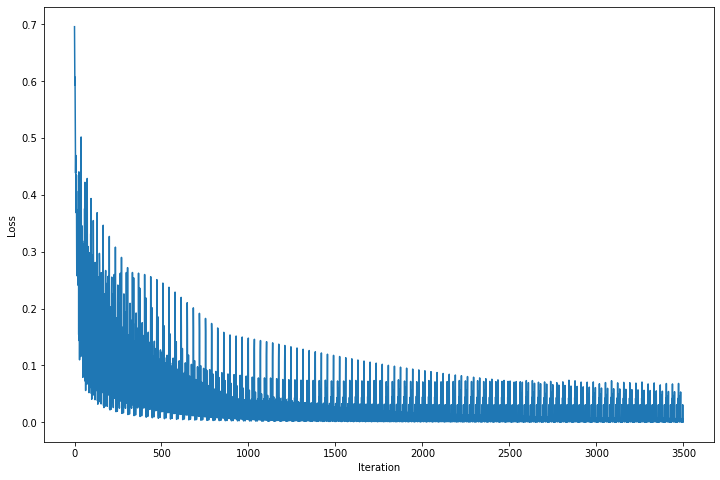

In [62]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [63]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = model(x_batch)
        probs = torch.sigmoid(outp)
        preds = (probs > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    predictions = predictions
    return predictions.flatten()

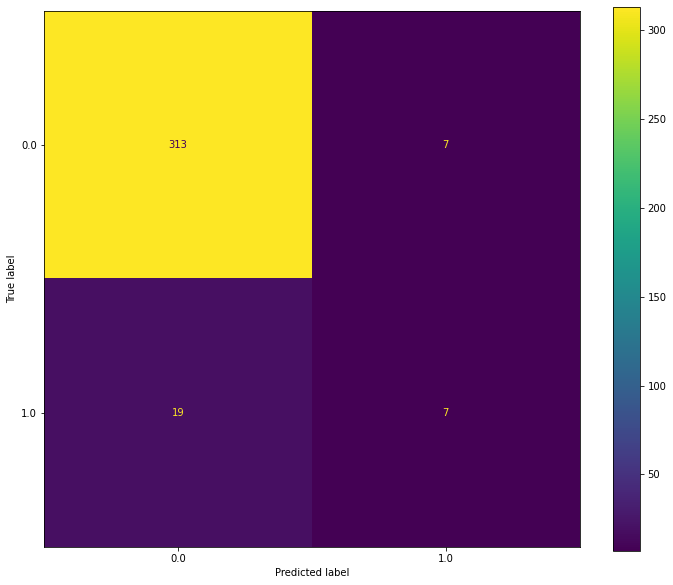

In [64]:
ConfusionMatrixDisplay.from_predictions(y_test, predict(test_dataloader, neural_n))

In [65]:
!pip install captum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 28.7 MB/s 


In [66]:
from captum.attr import IntegratedGradients

In [67]:
ig = IntegratedGradients(neural_n)

In [68]:
X_test.requires_grad_()
attr, delta = ig.attribute(X_test, return_convergence_delta=True)
attr = attr.detach().numpy()

Average Feature Importances
           feature  importance
1479  feature_1480    0.064106
231    feature_232    0.035326
1531  feature_1532    0.034049
465    feature_466    0.030069
1513  feature_1514    0.023011


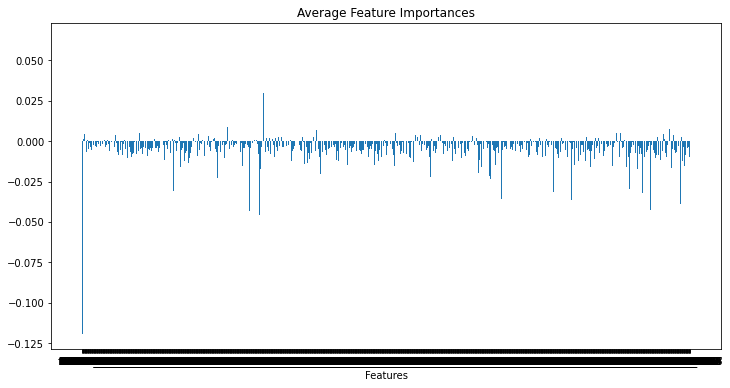

In [69]:
def visualize_importances(feature_cols, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    features = pd.DataFrame(columns=['feature', 'importance'])
    for i in range(len(feature_cols)):
        features.loc[i] = [feature_cols[i], importances[i]]
    print(features.nlargest(5, 'importance'))
    x_pos = (np.arange(len(feature_cols)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_cols, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)
visualize_importances(feature_cols, np.mean(attr, axis=0))
